## Training Gymnasium  Environment to validate the PPO implementation 

### This is sanity check before its implementation can be used in the model

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from gymnasium import Env

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

reward_in_episodes=[]
running_average = 0

class ActorNetwork(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, out_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        result = F.softmax(self.fc3(x), dim=-1)
        dist = Categorical(result)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action,log_prob,dist
    
class CriticNetwork(nn.Module):
    def __init__(self, inp_dim, out_dim):      
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, out_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        result = self.fc3(x)
        return  result

c:\Users\ijaje\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training CartPole

In [27]:
env = gym.make("CartPole-v1")
reward_in_episodes=[]
modelActor = ActorNetwork(env.observation_space.shape[0], env.action_space.n).to(device)
optimizerActor = optim.Adam(modelActor.parameters(), lr=0.001)
modelCritic = CriticNetwork(env.observation_space.shape[0],1).to(device)
optimizerCritic = optim.Adam(modelCritic.parameters(), lr=0.001)


In [10]:


class PPOTrainer(object):
    def __init__(self, env: Env,num:int,gamma:float,batchsize:int,updatesize:int):
        self.env = env
        self.num_episodes = num
        self.gamma = gamma
        
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.action=[]
        self.states=[]
        self.terminate = []
        self.batchsize = batchsize
        self.updatesize= updatesize
        self.eps_clip=0.2
        self.maxtime = 700
        self.interval = 4* self.maxtime

    def train(self):

        global_time = 0
        
        for i in range(self.num_episodes):
            env = self.env
            state, info = env.reset()
            done = False
            cumm=0
            step =0

            # if((i>0)):
            #     self.updateA2C()

            #     self.rewards = []
            #     self.log_probs = []
            #     self.values = []
            #     self.states=[]
            #     self.action=[]
            #     self.terminate=[]

            while ((not done) and (step < self.maxtime)):
                state = torch.from_numpy(state).float().unsqueeze(0).to(device)
                self.states.append(state) 
                action,log_prob,_ = modelActor(state)
                value = modelCritic(state)
                state, reward, terminated, truncated, _ = env.step(action.item())
                self.log_probs.append(log_prob)
                self.values.append(value)
                self.rewards.append(reward)
                self.action.append(action)



                done = terminated or truncated
                cumm+= reward
                step+=1
                global_time+=1

                self.terminate.append(done)

                modFlag = (global_time % self.interval)


                if((modFlag ==0) & (i>0)):
                    self.update()

                    self.rewards = []
                    self.log_probs = []
                    self.values = []
                    self.states=[]
                    self.action=[]
                    self.terminate=[]




            reward_in_episodes.append(cumm)
            if((i)>100):
                running_average=np.mean(reward_in_episodes[-100:])
            else: 
                running_average=0

            if i % 50 == 0:
                print(f"Episode {i},Rewards {cumm},mean {running_average}")
            if (running_average > 210):
                break
        

    def update(self):
            
            policy_loss = []
            value_loss = []
            n_steps = len(self.rewards)
            QvalueMC = torch.empty(n_steps, dtype=torch.float).to(device)

            Qvalue=0
            for j in reversed(range(n_steps)):
                if self.terminate[j]:
                    Qvalue=0
                Qvalue = self.rewards[j] + self.gamma * Qvalue
                QvalueMC[j] = Qvalue
            mean_ = torch.mean((QvalueMC))
            std_ = torch.std(QvalueMC)
            if (std_!=0):
                QvalueMC = (QvalueMC-mean_)/(std_)
            values = torch.stack(self.values).squeeze()
            log_probs_old = torch.stack(self.log_probs).squeeze()
            advantage = QvalueMC - values
            states= torch.stack(self.states).squeeze()
            actions= torch.stack(self.action).squeeze()
            

            for j in range(self.updatesize):
                _,_,dist = modelActor(states)
                log_prob=dist.log_prob(actions)
                value = modelCritic(states)
                state_values = torch.squeeze(value) 
                dist_entropy = dist.entropy()               
                ratios = torch.exp(log_prob - log_probs_old.detach())
                surr1 = ratios * advantage.detach()
                surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantage.detach()              
                policy_loss = torch.sum((-torch.min(surr1, surr2)) - 0.0*dist_entropy )
                criterion = nn.MSELoss()

                value_loss = criterion(state_values, QvalueMC)
                optimizerActor.zero_grad()
                optimizerCritic.zero_grad()

                #policy_loss = torch.sum(torch.stack(policy_loss))
                value_loss.backward()
                optimizerCritic.step()
                policy_loss.backward()
                optimizerActor.step()


    def updateA2C(self):
            
            policy_loss = []
            value_loss = []
            n_steps = len(self.rewards)
            QvalueMC = torch.empty(n_steps, dtype=torch.float).to(device)
            Qvalue = 0
            for j in reversed(range(n_steps)):
                Qvalue = self.rewards[j] + self.gamma * Qvalue
                QvalueMC[j] = Qvalue


            mean_ = torch.mean((QvalueMC))
            std_ = torch.std(QvalueMC)
            if (std_!=0):
                QvalueMC = (QvalueMC-mean_)/(std_)



            values = torch.stack(self.values).squeeze()
            log_probs = torch.stack(self.log_probs).squeeze()
            advantage = QvalueMC - values
            
            policy_loss = torch.sum(-log_probs * advantage.detach())

            # Critic loss
            criterion = nn.MSELoss()
            value_loss = criterion(values, QvalueMC)

            optimizerActor.zero_grad()
            optimizerCritic.zero_grad()

            #policy_loss = torch.sum(torch.stack(policy_loss))
            value_loss.backward()
            optimizerCritic.step()
            policy_loss.backward()
            optimizerActor.step()

    def evaluate(self):

        global_time = 0
        
        for i in range(150):
            env = self.env
            state, info = env.reset()
            done = False
            cumm=0
            step =0

            while ((not done) and (step < self.maxtime)):
                state = torch.from_numpy(state).float().unsqueeze(0).to(device)
                self.states.append(state) 
                action,log_prob,_ = modelActor(state)
                value = modelCritic(state)
                state, reward, terminated, truncated, _ = env.step(action.item())
                self.log_probs.append(log_prob)
                self.values.append(value)
                self.rewards.append(reward)
                self.action.append(action)

                step=step+1



                done = terminated or truncated
                cumm+= reward
            reward_in_episodeseval.append(cumm)





## Training on CartPole

In [29]:
trainer = PPOTrainer(env,2000,0.98,4,40)
trainer.train()

Episode 0,Rewards 13.0,mean 0
Episode 50,Rewards 14.0,mean 0
Episode 100,Rewards 124.0,mean 0
Episode 150,Rewards 38.0,mean 28.16
Episode 200,Rewards 38.0,mean 35.1
Episode 250,Rewards 144.0,mean 59.34
Episode 300,Rewards 335.0,mean 152.63
Episode 350,Rewards 500.0,mean 337.65
Episode 400,Rewards 500.0,mean 436.31
Episode 450,Rewards 500.0,mean 455.26


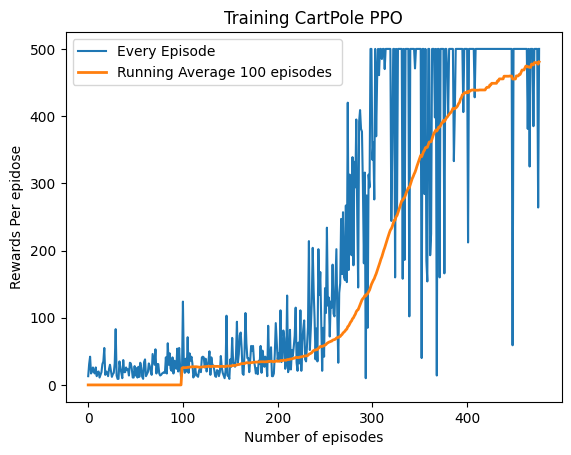

In [30]:
plt.plot(reward_in_episodes)
durations_t = torch.tensor(reward_in_episodes, dtype=torch.float).to(device)
means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
means = torch.cat((torch.zeros(99).to(device), means))
plt.plot(means.cpu().numpy(), label='Running Average Duration', linewidth=2)
plt.xlabel('Number of episodes')
plt.ylabel('Rewards Per epidose')
plt.legend(['Every Episode','Running Average 100 episodes '])
plt.title('Training CartPole PPO')
plt.show()

In [31]:
reward_in_episodeseval=[]
trainer.evaluate()

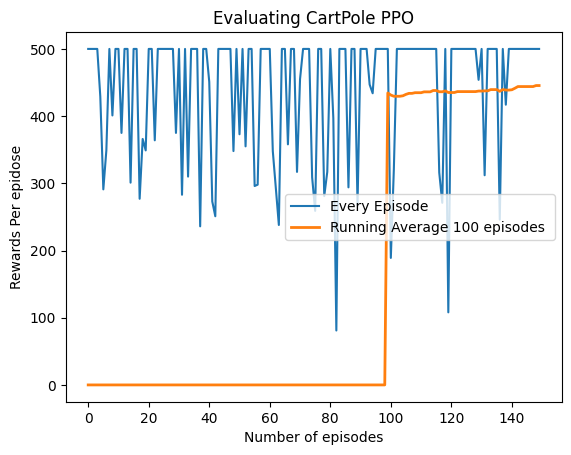

In [32]:
plt.plot(reward_in_episodeseval)
durations_t = torch.tensor(reward_in_episodeseval, dtype=torch.float).to(device)
means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
means = torch.cat((torch.zeros(99).to(device), means))
plt.plot(means.cpu().numpy(), label='Running Average Duration', linewidth=2)
plt.xlabel('Number of episodes')
plt.ylabel('Rewards Per epidose')
plt.legend(['Every Episode','Running Average 100 episodes '])
plt.title('Evaluating CartPole PPO')
plt.show()

## Training Lunar Lander

The run is stopped once the 100 moving episodes has average of 200

In [11]:
env = gym.make("LunarLander-v2")
reward_in_episodes=[]
modelActor = ActorNetwork(env.observation_space.shape[0], env.action_space.n).to(device)
optimizerActor = optim.Adam(modelActor.parameters(), lr=0.0008)
modelCritic = CriticNetwork(env.observation_space.shape[0],1).to(device)
optimizerCritic = optim.Adam(modelCritic.parameters(), lr=0.001)

In [12]:
trainer = PPOTrainer(env,2500,0.98,4,40)
trainer.train()

Episode 0,Rewards -144.38284148763998,mean 0
Episode 50,Rewards -161.0054099517542,mean 0
Episode 100,Rewards -113.44842733759752,mean 0
Episode 150,Rewards -85.45893028774243,mean -102.50956818852848
Episode 200,Rewards -18.952605790681673,mean -74.46930732637207
Episode 250,Rewards -7.990861900628232,mean -14.410975204244178
Episode 300,Rewards 137.64493759346723,mean 66.0352984925417
Episode 350,Rewards -2.0828587627398463,mean 104.14673964447559
Episode 400,Rewards 277.4022143454812,mean 132.12492701429835
Episode 450,Rewards 31.201994216423998,mean 184.76505868414608


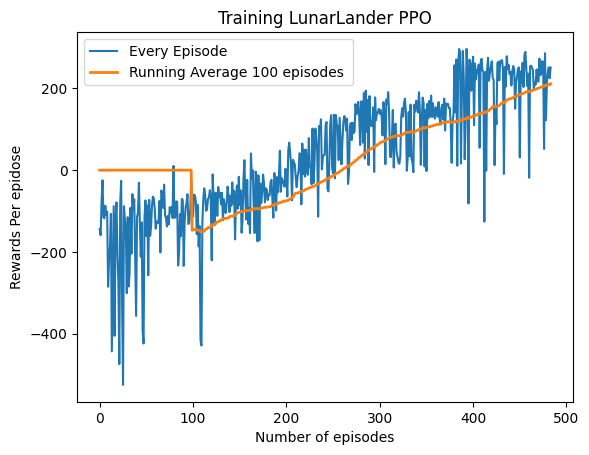

In [13]:
plt.plot(reward_in_episodes)
durations_t = torch.tensor(reward_in_episodes, dtype=torch.float).to(device)
means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
means = torch.cat((torch.zeros(99).to(device), means))
plt.plot(means.cpu().numpy(), label='Running Average Duration', linewidth=2)
plt.xlabel('Number of episodes')
plt.ylabel('Rewards Per epidose')
plt.legend(['Every Episode','Running Average 100 episodes '])
plt.title('Training LunarLander PPO')
plt.show()

### Evaluating Lander 

In [14]:
reward_in_episodeseval=[]
trainer.evaluate()

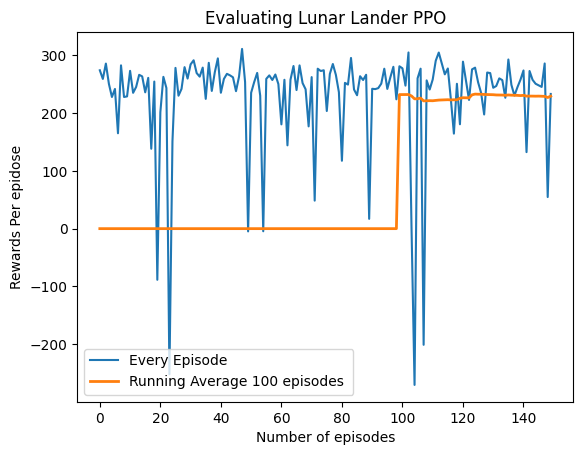

In [15]:
plt.plot(reward_in_episodeseval)
durations_t = torch.tensor(reward_in_episodeseval, dtype=torch.float).to(device)
means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
means = torch.cat((torch.zeros(99).to(device), means))
plt.plot(means.cpu().numpy(), label='Running Average Duration', linewidth=2)
plt.xlabel('Number of episodes')
plt.ylabel('Rewards Per epidose')
plt.legend(['Every Episode','Running Average 100 episodes '])
plt.title('Evaluating Lunar Lander PPO')
plt.show()